In [1]:
# import the necessary packages
import numpy as np
import gzip, os
from urllib.request import urlretrieve
from random import random
from math import exp
from random import seed
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
#The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1].
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:04<00:00, 35799481.52it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])


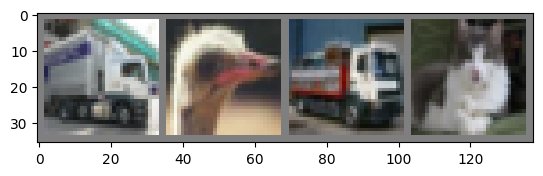

truck bird  truck cat  


In [3]:
## Let us show some of the training images, for fun.

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

for image in images:
  print(image.shape)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

Create a neural network that take 3-channel images. It should go as Conv2d --> ReLU --> MaxPool2d --> Conv2d --> ReLU --> MaxPool2d --> Flatten --> Linear --> ReLU --> Linear --> ReLU --> Linear

In [4]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        #images are 3x32x32 -> nn -> 0-9 (10 classes)
        self.conv1 = nn.Conv2d(3,1024,5)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2,2)
        #======================================================
        self.conv2 = nn.Conv2d(1024,128,5)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2,2)
        #======================================================
        self.flatten = nn.Flatten()
        #======================================================
        self.f1 = nn.Linear(128*5*5, 256)
        self.relu3 = nn.ReLU()
        #======================================================
        self.f2 = nn.Linear(256,128)
        self.relu4 = nn.ReLU()
        #======================================================
        self.f3 = nn.Linear(128,10)

    def forward(self, x):
        # run forward pass as mentioned above.
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))

        x = self.flatten(x)

        x = self.relu3(self.f1(x))
        x = self.relu4(self.f2(x))
        x = self.f3(x)
        return x


net = Net()
net = net.cuda()

In [5]:
criterion = torch.nn.CrossEntropyLoss() #Add loss function
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.95) #Add optimizer

Loop over our data iterator, and feed the inputs to the network and optimize.

[1,  2000] loss: 1.907
[1,  4000] loss: 1.594
[1,  6000] loss: 1.496
[1,  8000] loss: 1.350
[1, 10000] loss: 1.282
[1, 12000] loss: 1.228
[2,  2000] loss: 1.123
[2,  4000] loss: 1.079
[2,  6000] loss: 1.059
[2,  8000] loss: 1.018
[2, 10000] loss: 1.019
[2, 12000] loss: 0.976
[3,  2000] loss: 0.849
[3,  4000] loss: 0.867
[3,  6000] loss: 0.840
[3,  8000] loss: 0.853
[3, 10000] loss: 0.843
[3, 12000] loss: 0.865
[4,  2000] loss: 0.684
[4,  4000] loss: 0.714
[4,  6000] loss: 0.725
[4,  8000] loss: 0.755
[4, 10000] loss: 0.735
[4, 12000] loss: 0.727
[5,  2000] loss: 0.599
[5,  4000] loss: 0.618
[5,  6000] loss: 0.619
[5,  8000] loss: 0.635
[5, 10000] loss: 0.640
[5, 12000] loss: 0.643


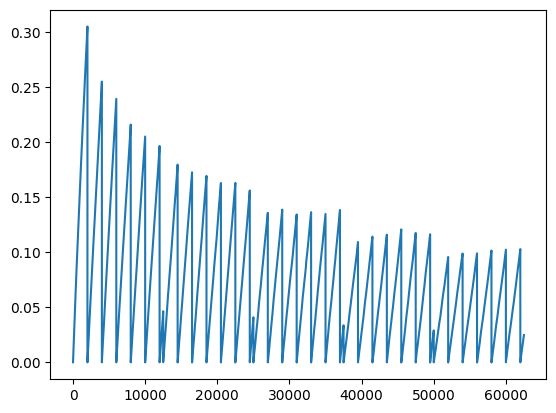

Finished Training


In [6]:
epochs = 5 # define number of epochs to train
losses = []
for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        labels = labels.cuda()
        inputs = inputs.cuda()
        # add line to zero the parameter gradients below
        optimizer.zero_grad()
        criterion.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        losses.append(running_loss / len(trainloader))

        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
plt.plot(losses)
plt.show()
print('Finished Training')

# save our trained model:

PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

Check our model by predicting the class label that the neural network outputs, and checking it against the ground-truth. If the prediction is correct, we add the sample to the list of correct predictions.


In [7]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 71.5 %
Accuracy for class: car   is 85.6 %
Accuracy for class: bird  is 62.7 %
Accuracy for class: cat   is 51.5 %
Accuracy for class: deer  is 71.8 %
Accuracy for class: dog   is 36.9 %
Accuracy for class: frog  is 88.5 %
Accuracy for class: horse is 80.1 %
Accuracy for class: ship  is 83.6 %
Accuracy for class: truck is 73.5 %
